<a href="https://colab.research.google.com/github/alicej06/email-phishing-detection/blob/main/Email_Phishing_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

import pandas as pd
import numpy as np
work_dir = '/content/drive/MyDrive/CAIS_Email_Phishing_Detection/'

# loading in all csv's
df1 = pd.read_csv(work_dir + 'CEAS_08.csv')
df2 = pd.read_csv(work_dir + 'Enron.csv')
df3 = pd.read_csv(work_dir + 'Ling.csv')
df4 = pd.read_csv(work_dir + 'Nazario.csv')
df5 = pd.read_csv(work_dir + 'Nigerian_Fraud.csv')
df6 = pd.read_csv(work_dir + 'phishing_email.csv')
df7 = pd.read_csv(work_dir + 'SpamAssasin.csv')

In [3]:
# extract out only the columns for 'body' and 'label' for each df
df1 = df1[['body', 'label']]
df2 = df2[['body', 'label']]
df3 = df3[['body', 'label']]
df4 = df4[['body', 'label']]
df5 = df5[['body', 'label']]
df6 = df6[['text_combined', 'label']]
df6.rename(columns={'text_combined': 'body'}, inplace=True)
df7 = df7[['body', 'label']]

# append the dfs together
df = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index=True)
df

,body,label
0,"Buck up, your troubles caused by small dimensi...",1
1,\nUpgrade your sex and pleasures with these te...,1
2,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
3,Would anyone object to removing .so from this ...,0
4,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1
...,...,...
164967,\n\n \n--- \n![](http://images.pcdi-homestud...,1
164968,This is a multi-part message in MIME format. -...,1
164969,"Dear Subscriber,\n\nIf I could show you a way ...",1
164970,****Mid-Summer Customer Appreciation SALE!****...,1


In [4]:
import torch, transformers, datasets, accelerate

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
df.shape
# dataset size: 164,972

(164972, 2)

In [6]:
emails = df['body'].values
labels = df['label'].values

emails = emails[:1000] # due to RAM limitations, training with a smaller portion of the dataset
labels = labels[:1000]

from sklearn.model_selection import train_test_split

emails_train, emails_val, labels_train, labels_val = train_test_split(
    emails,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)


In [7]:
import torch
from transformers import BertTokenizerFast, BertModel
import torch.nn as nn

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").to(DEVICE)

MAX_CHUNK_LEN = 510
STRIDE = 510

def chunk_email(text):
    tokens = tokenizer(
        text,
        add_special_tokens=False,
        truncation=False
    )["input_ids"]

    chunks = []
    for i in range(0, len(tokens), STRIDE):
        chunk = tokens[i:i + MAX_CHUNK_LEN]
        chunk = tokenizer.build_inputs_with_special_tokens(chunk)
        chunks.append(chunk)

    return chunks


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
from torch.utils.data import Dataset

class EmailDataset(Dataset):
    def __init__(self, emails, labels):
        self.emails = emails.astype(str).tolist()
        self.labels = labels

    def __len__(self):
        return len(self.emails)

    def __getitem__(self, idx):
        return {
            "chunks": chunk_email(self.emails[idx]),
            "label": self.labels[idx]
        }

def collate_fn(batch):
    all_chunks = []
    chunk_counts = []
    labels = []

    for item in batch:
        all_chunks.extend(item["chunks"])
        chunk_counts.append(len(item["chunks"]))
        labels.append(item["label"])

    max_len = max(len(c) for c in all_chunks)

    input_ids = []
    attention_masks = []

    for c in all_chunks:
        pad_len = max_len - len(c)
        input_ids.append(c + [tokenizer.pad_token_id] * pad_len)
        attention_masks.append([1]*len(c) + [0]*pad_len)

    return {
        "input_ids": torch.tensor(input_ids),
        "attention_mask": torch.tensor(attention_masks),
        "chunk_counts": chunk_counts,
        "labels": torch.tensor(labels)
    }



In [9]:
class HierarchicalBERT(nn.Module):
    def __init__(self, bert, hidden_size=768, num_labels=2):
        super().__init__()
        self.bert = bert
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, chunk_counts):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        cls_embeddings = outputs.last_hidden_state[:, 0]  # [CLS]

        pooled = []
        idx = 0
        for count in chunk_counts:
            pooled.append(cls_embeddings[idx:idx+count].mean(dim=0))
            idx += count

        pooled = torch.stack(pooled)
        return self.classifier(pooled)


In [10]:
from torch.utils.data import DataLoader

train_dataset = EmailDataset(emails_train, labels_train)
val_dataset   = EmailDataset(emails_val, labels_val)

train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)



In [11]:
model = HierarchicalBERT(bert).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

model.train()

for batch in train_loader:
    input_ids = batch["input_ids"].to(DEVICE)
    attention_mask = batch["attention_mask"].to(DEVICE)
    labels = batch["labels"].to(DEVICE)

    logits = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        chunk_counts=batch["chunk_counts"]
    )

    loss = loss_fn(logits, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


Token indices sequence length is longer than the specified maximum sequence length for this model (1463 > 512). Running this sequence through the model will result in indexing errors


In [12]:
from sklearn.metrics import classification_report, roc_auc_score
import torch.nn.functional as F

model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            chunk_counts=batch["chunk_counts"]
        )

        probs = F.softmax(logits, dim=-1)[:, 1]
        preds = torch.argmax(logits, dim=-1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))
print("ROC-AUC:", roc_auc_score(all_labels, all_probs))


              precision    recall  f1-score   support

           0       1.00      0.95      0.97        80
           1       0.97      1.00      0.98       120

    accuracy                           0.98       200
   macro avg       0.98      0.97      0.98       200
weighted avg       0.98      0.98      0.98       200

ROC-AUC: 1.0


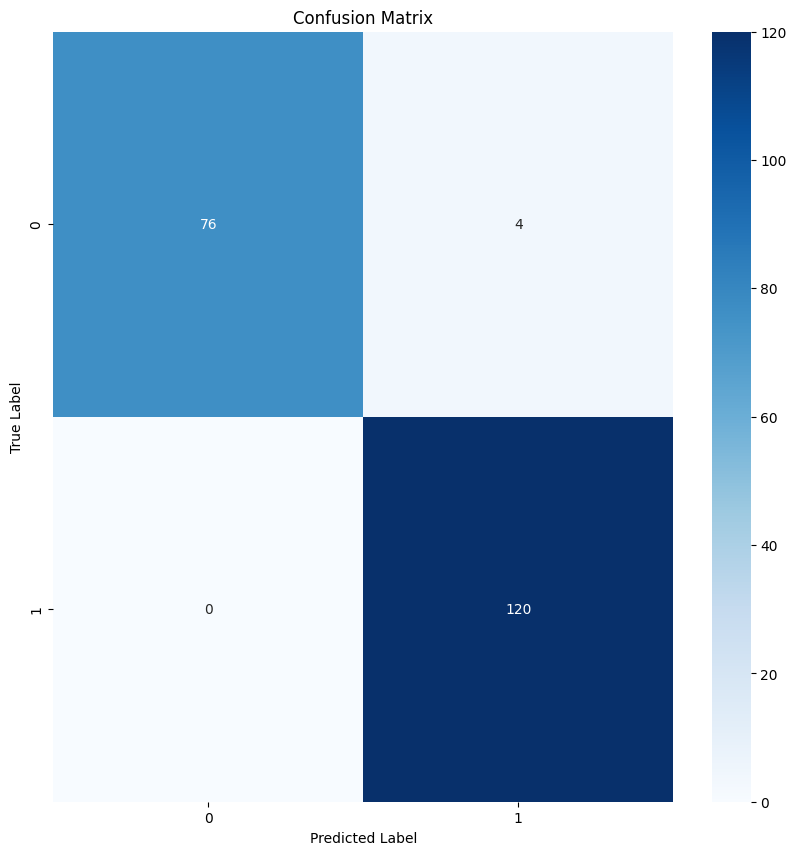

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
